In [1]:
!pip install bayesian-optimization
!pip install pyproj

import pandas as pd
import numpy as np
import random
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge,Lasso
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import cross_val_score
from pyproj import Proj,transform
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score   # AUC 스코어 계산
from sklearn.metrics import accuracy_score,log_loss,f1_score
from sklearn.model_selection import KFold,StratifiedKFold   # K-fold CV    
from sklearn.metrics import classification_report
from bayes_opt import BayesianOptimization  # 베이지안 최적화 라이브러리  
from functools import partial               # 함수 변수 고정
import lightgbm as lgb                      # LightGBM 라이브러리
import warnings       
warnings.filterwarnings("ignore")
import numpy as np
from imblearn.over_sampling import SMOTE

from sklearn.datasets.samples_generator import make_blobs
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

     |████████████████████████████████| 10.4MB 3.2MB/s 


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 25 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Selecting previously unselected package fonts-nanum.
(Reading database ... 144568 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


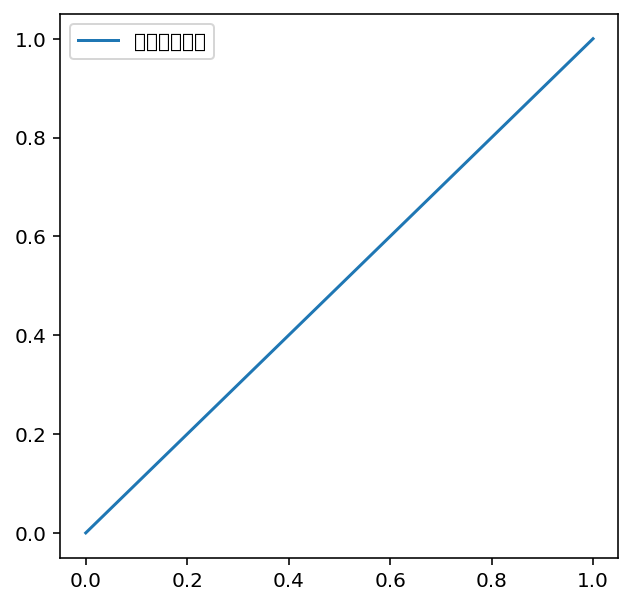

In [3]:
plt.figure(figsize=(5,5))
plt.plot([0,1], [0,1], label='한글테스트용')
plt.legend()
plt.show()

# DBSCAN
- 소로, old/building, crosswork, bus

In [0]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/공모전/동작구_공모전/sell_십만_150.csv',encoding='cp949')
data.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1,inplace=True)

In [0]:
# 파생변수 제작
data['old/building'] = data['old_place']/data['building']
data['child/building'] = data['child_place']/data['building']

In [6]:
data.head()

,x,y,소로,중로2류,소로1류,소로3류,중로3류,소로2류,중로1류,광로2류,old_place,child_place,crosswork,building,bus,bohang,accident,old_acc,old/building,child/building
0,195600.888993,545928.299315,6,0,0,1,0,0,0,0,0.0,1.0,5.0,93.0,45.0,0.0,0.0,0.0,0.000000,0.010753
1,194062.308207,544725.091085,19,0,0,1,0,0,0,0,1.0,3.0,4.0,219.0,2.0,0.0,2.0,1.0,0.004566,0.013699
2,197377.867009,543986.683138,0,0,0,0,0,0,0,0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.000000,0.000000
3,193058.182323,543489.087262,0,0,0,0,0,0,0,0,0.0,1.0,1.0,14.0,0.0,0.0,0.0,0.0,0.000000,0.071429
4,197347.383013,542701.828076,23,0,0,3,0,0,0,0,4.0,2.0,3.0,258.0,4.0,0.0,1.0,1.0,0.015504,0.007752


In [0]:
robust_scaler = RobustScaler()

x=data[['old/building','bus','소로','crosswork']]
x.replace([np.inf, -np.inf], 0, inplace=True)
x.fillna(0,inplace=True)
scaled_X=robust_scaler.fit_transform(x)

In [8]:
scaled_X

array([[ 0.        ,  5.375     ,  0.06666667,  0.42857143],
       [ 0.44748858,  0.        ,  0.93333333,  0.28571429],
       [ 0.        , -0.25      , -0.33333333, -0.28571429],
       ...,
       [ 0.        ,  0.        , -0.33333333,  0.28571429],
       [ 0.        , -0.25      ,  1.06666667, -0.28571429],
       [ 0.        , -0.25      , -0.33333333, -0.28571429]])

DBSCAN 선언

In [10]:
scan_model = DBSCAN()
clusters=scan_model.fit_predict(scaled_X)
print('클러스터 레이블:\n',clusters)

클러스터 레이블:
 [0 0 0 ... 0 0 0]


In [11]:
pd.Series(clusters).value_counts()

 0     47922
-1       108
 3        89
 2        42
 1        21
 5        19
 8        16
 9        14
 10       12
 4        12
 13       10
 11       10
 12        8
 6         8
 7         6
 15        5
 14        5
 16        5
dtype: int64

In [0]:
data['clusters'] = clusters

# Map 시각화
- 37.503031, 126.947982 동작구 좌표

In [0]:
proj_WGS84 = Proj(init='epsg:4326') # epsg:4326
proj_UTMK = Proj(init='epsg:5186')
def transform_utmk_to_w84(df):
    return pd.Series(transform(proj_UTMK,proj_WGS84,df['x'],df['y']),index=['x','y'])

In [0]:
map_cluster=data[data['clusters']>0]

In [18]:
map_cluster

,x,y,소로,중로2류,소로1류,소로3류,중로3류,소로2류,중로1류,광로2류,old_place,child_place,crosswork,building,bus,bohang,accident,old_acc,old/building,child/building,clusters
230,196298.416761,544646.166942,0,0,0,0,0,0,0,0,3.0,3.0,0.0,15.0,0.0,0.0,0.0,0.0,0.200000,0.200000,1
490,195637.158770,546045.721767,1,0,1,0,0,0,0,0,2.0,1.0,20.0,26.0,22.0,0.0,0.0,0.0,0.076923,0.038462,11
722,193547.539829,546163.609863,1,0,0,0,0,0,0,0,1.0,0.0,2.0,6.0,1.0,0.0,0.0,0.0,0.166667,0.000000,2
1185,192751.909671,543474.466651,0,0,0,0,0,0,0,0,1.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.142857,0.000000,3
1188,194981.584672,546018.974549,9,0,0,0,0,0,0,0,0.0,0.0,14.0,122.0,51.0,0.0,1.0,0.0,0.000000,0.000000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47498,193379.127444,545488.544731,0,0,0,0,0,0,0,0,3.0,1.0,8.0,40.0,20.0,0.0,0.0,0.0,0.075000,0.025000,10
47653,194989.252326,546004.878685,11,0,0,0,0,0,0,0,0.0,0.0,14.0,143.0,51.0,0.0,1.0,0.0,0.000000,0.000000,4
47788,192768.554948,543474.990119,0,0,0,0,0,0,0,0,1.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.166667,0.000000,2
47947,196070.414820,544805.131642,0,0,0,0,0,0,0,0,2.0,1.0,2.0,12.0,1.0,0.0,0.0,0.0,0.166667,0.083333,2


In [0]:
map_cluster[['X좌표','Y좌표']]= map_cluster.apply(transform_utmk_to_w84,axis=1)

In [20]:
map_cluster['clusters'].value_counts()

3     89
2     42
1     21
5     19
8     16
9     14
10    12
4     12
13    10
11    10
12     8
6      8
7      6
16     5
15     5
14     5
Name: clusters, dtype: int64

In [0]:
import folium
from folium.plugins import FastMarkerCluster

In [23]:
map= folium.Map(location=[map_cluster['Y좌표'].mean(),map_cluster['X좌표'].mean()],tiles='Stamen Terrain',zoom_start=14)
for i in map_cluster.index:
    folium.Map(location=[map_cluster['Y좌표'].mean(),map_cluster['X좌표'].mean()],tiles='Stamen Terrain',zoom_start=14)
    
    if map_cluster.loc[i, 'clusters'] == 1 :
          icon_color = 'green'
    elif map_cluster.loc[i, 'clusters'] == 2 :
          icon_color = 'blue' 
    elif map_cluster.loc[i, 'clusters'] == 3 :
          icon_color = 'yellow'
    elif map_cluster.loc[i, 'clusters'] == 4 :
          icon_color = 'red'
    elif map_cluster.loc[i, 'clusters'] == 5 :
          icon_color = 'black'
    elif map_cluster.loc[i, 'clusters'] == 6 :
          icon_color = 'pink'
    elif map_cluster.loc[i, 'clusters'] == 7 :
          icon_color = 'pink'
    # elif map_cluster.loc[i, 'clusters'] == 8 :
        
    # elif map_cluster.loc[i, 'clusters'] == 9 :
        
    # elif map_cluster.loc[i, 'clusters'] == 10 :
        
    # elif map_cluster.loc[i, 'clusters'] == 11 :
        
    # elif map_cluster.loc[i, 'clusters'] == 12 :
        
    # elif map_cluster.loc[i, 'clusters'] == 13 :
        
    # elif map_cluster.loc[i, 'clusters'] == 14 :
        
    # elif map_cluster.loc[i, 'clusters'] == 15 :
        
    # else:
    
    folium.RegularPolygonMarker(
        
        location = [map_cluster.loc[i,'Y좌표'],map_cluster.loc[i,'X좌표']],
        number_of_sides=5,
        color = icon_color,
        fill_color = icon_color,
        radius= 4
    ).add_to(map)

map